<a href="https://colab.research.google.com/github/alfredamboka/DeepTech5Yr/blob/main/mainProjectCode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Initialization
- Authontication and Module loads

In [1]:
import ee
ee.Authenticate()
ee.Initialize()


To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=eoWKjfznQ1uBLoZaldbqhwbGdq3w_4Q7d7Nae_V10SY&tc=nh5I4846gLEfIbQxblsXcovz7FPTBIVtq5b0YGAkfC8&cc=lTBnKp5YCAM7E5z7ksOJ6wXceifhFQER2qIiZpSkcY0

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1AZEOvhVyswYSIPsb2gQ-fe9edMMgWUQVvna96Yac6TOOFUYNvnIy0u4fAZw

Successfully saved authorization token.


install and import geemap for convertion on js to py
Only applicable to Colab. In other cases or environment install normally and comment the cell below.

In [2]:
try:
    import geemap
except ModuleNotFoundError:
    if 'google.colab' in str(get_ipython()):
        print('geemap not found, installing via pip in Google Colab...')
        !pip install geemap --quiet
        import geemap
    else:
        print('geemap not found, please install via conda in your environment')

Map = geemap.Map()


geemap not found, installing via pip in Google Colab...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 56.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.5/130.5 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 63.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 52.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 62.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.7/56.7 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 40.5 MB/s eta 0:00:00


important geometries for study localization

In [3]:
cropland = ee.FeatureCollection('projects/project5yr/assets/Croplands').geometry()

##J.S - P.y
Code to automatically convert GEE code from JavaScript to Python
- The cell below is used.
- Any js code provided will be converted to python.
- Write python code and js code in different cells

In [4]:
javascript_code = """
// Series of strings here!


"""

In [5]:
lines = geemap.js_snippet_to_py(
    javascript_code, add_new_cell=False,
    import_ee=True, import_geemap=True, show_map=True)
for line in lines:
    print(line.rstrip())

import ee
import geemap
Map = geemap.Map()
import geemap

Map = geemap.Map()

# Series of strings here!

Map


## Datasets
- Load all the required dataset in this section.


In [6]:
#Imagery and filter based on growing for the two seasons.


# Function to mask clouds using the Sentinel-2 QA band
def maskClouds(image):
    qa = image.select('QA60')
    cloudBitMask = 1 << 10
    cirrusBitMask = 1 << 11
    mask = qa.bitwiseAnd(cloudBitMask).eq(0).And(qa.bitwiseAnd(cirrusBitMask).eq(0))
    return image.updateMask(mask)

# Function to calculate NDVI
def calculateNDVI(image):
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
    return image.addBands(ndvi)

# Load Sentinel-2 image collection and apply cloud masking
s2_collection = ee.ImageCollection('COPERNICUS/S2_SR').filterDate('2018-01-01', '2022-12-31').filterBounds(cropland).map(maskClouds)


Climate related dataset - ERA5 daily dataset

In [ ]:
#consisting of incoming radiation, windspeed, Temperature, humidity, Precipitation, vapour pressure etc.



## Crop Phenology Extraction
- Used to determine the growing seasons
- Also used to aid in futher data filtering.




Extraction ofcrop phenlogical periods usng NDVI and EVI Curves Image fusion of sentinel and Modis used.


Only EVI curve using fused sentinel and MODIS Data.superimposed graphs  at two years interval for proper visualization


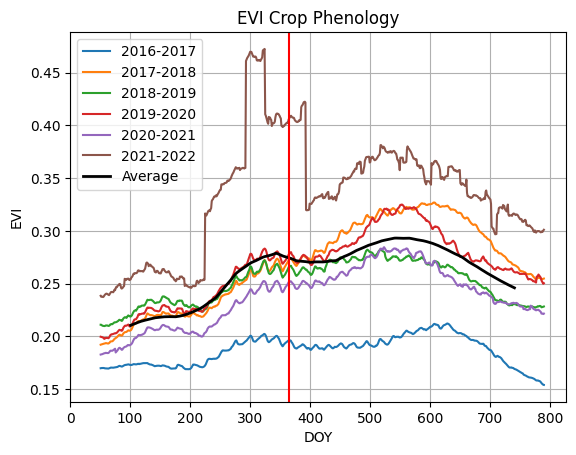

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define study area
#study_area = ee.FeatureCollection('projects/project5yr/assets/Croplands').geometry()
study_area = ee.FeatureCollection('projects/project5yr/assets/BuraStudyArea').geometry()

# Create a list of years from 2018 to 2022
years = range(2017, 2023)

# Create empty lists to store the mean values for each year
evi_mean_values = []

# Create an empty DataFrame to store all EVI values
all_evi_df = pd.DataFrame()

# Iterate over each year
for year in years:
    # Define start and end dates for the current year
    start_date = f'{year}-01-01'
    end_date = f'{year}-12-31'

    # Load Sentinel-2, Landsat, and MODIS images for the current year
    sentinel = ee.ImageCollection('COPERNICUS/S2_SR') \
        .filterBounds(study_area) \
        .filterDate(start_date, end_date) \
        .map(lambda image: image.clip(study_area)) \
        .map(lambda image: image.updateMask(image.select(['QA60']).bitwiseAnd(2 ** 10).eq(0))) \
        .map(lambda image: image.divide(10000).float()) \
        .map(lambda image: image.expression('2.5 * (b("B8") - b("B4")) / (1 + b("B8") + 6 * b("B4") - 7.5 * b("B2"))', {
            'B2': image.select('B2'),
            'B4': image.select('B4'),
            'B8': image.select('B8')
        }).rename('EVI').copyProperties(image, image.propertyNames()))

    landsat = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR') \
        .filterBounds(study_area) \
        .filterDate(start_date, end_date) \
        .map(lambda image: image.clip(study_area)) \
        .map(lambda image: image.divide(10000).float()) \
        .map(lambda image: image.expression('2.5 * (b("B5") - b("B4")) / (1 + b("B5") + 6 * b("B4") - 7.5 * b("B2"))', {
            'B4': image.select('B4'),
            'B5': image.select('B5'),
            'B2': image.select('B2')
        }).rename('EVI').copyProperties(image, image.propertyNames()))

    modis = ee.ImageCollection('MODIS/006/MOD13A1') \
        .filterBounds(study_area) \
        .filterDate(start_date, end_date) \
        .map(lambda image: image.clip(study_area)) \
        .map(lambda image: image.divide(10000).float()) \
        .select('EVI')

    # Merge the image collections
    image_collection = sentinel.merge(landsat).merge(modis)

    # Create a fusion function
    def fusionFunction(images):
        return ee.Image(images.mean())

    # Apply the fusion function to the image collection
    fused_image = image_collection.reduce(ee.Reducer.intervalMean(50, 100)).rename('EVI')

    # Reduce region and extract EVI values as a nested list
    evi_values = fused_image.reduceRegion(reducer=ee.Reducer.toList(), geometry=study_area, scale=500).getInfo()

    # Convert the nested list to a Pandas DataFrame
    evi_df = pd.DataFrame(evi_values.get('EVI'), columns=['EVI'])

    # Add day of the year (DOY) column
    evi_df['doy'] = range(1, len(evi_df) + 1)

    # Smooth curve using moving average
    evi_df['EVI_smooth'] = evi_df['EVI'].rolling(window=100, center=True).mean()

    # Fit curve using polynomial regression
    evi_fit = np.polyfit(evi_df['doy'], evi_df['EVI_smooth'], deg=6)

    # Calculate the mean EVI value for the current year
    evi_mean = evi_df['EVI'].mean()

    # Store the mean value
    evi_mean_values.append(evi_mean)

    # Merge the current year's EVI DataFrame with the overall DataFrame
    all_evi_df = pd.concat([all_evi_df, evi_df], ignore_index=True)

    # Plot EVI curve with fitted curve for the current year
    plt.plot(evi_df['doy'], evi_df['EVI_smooth'], label=f'{year-1}-{year}')

# Calculate the average EVI values across all years
avg_evi_df = all_evi_df.groupby('doy')['EVI_smooth'].mean().reset_index()

# Smooth the average EVI curve using moving average
avg_evi_df['EVI_avg_smooth'] = avg_evi_df['EVI_smooth'].rolling(window=100, center=True).mean()

# Fit curve using polynomial regression
avg_evi_fit = np.polyfit(avg_evi_df['doy'], avg_evi_df['EVI_avg_smooth'], deg=6)

# Plot the average EVI curve with the fitted curve
plt.plot(avg_evi_df['doy'], avg_evi_df['EVI_avg_smooth'], color='black', linewidth=2, label='Average')
plt.xlabel('DOY')
plt.ylabel('EVI')
plt.title('EVI Crop Phenology')
plt.legend()
plt.grid(True)

plt.xticks(np.arange(0, len(avg_evi_df['doy']), 730))
plt.xticks(np.arange(0, len(avg_evi_df['doy']), 100))
plt.axvline(x=365, color='red', linestyle='-')
plt.show()



Superimposed graphs. ONLY NDVI. Showing  Crop phenology between consecutive years and an average curve.

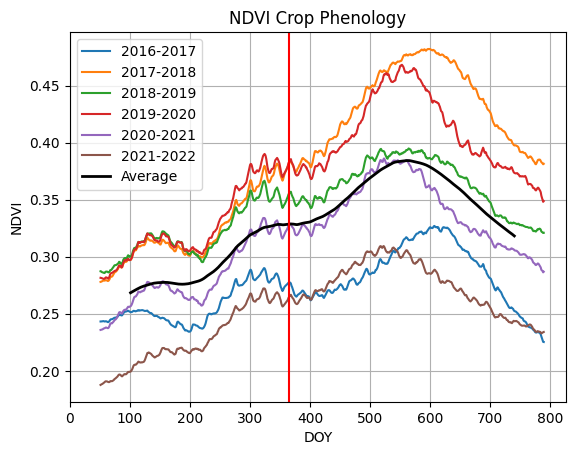

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define study area
#study_area = ee.FeatureCollection('projects/project5yr/assets/Croplands').geometry()
study_area = ee.FeatureCollection('projects/project5yr/assets/BuraStudyArea').geometry()

# Create a list of years from 2018 to 2022
years = range(2017, 2023)

# Create empty lists to store the mean values for each year
ndvi_mean_values = []

# Create an empty DataFrame to store all NDVI values
all_ndvi_df = pd.DataFrame()

# Iterate over each year
for year in years:
    # Define start and end dates for the current year
    start_date = f'{year}-01-01'
    end_date = f'{year}-12-31'

    # Load Sentinel-2, Landsat, and MODIS images for the current year
    sentinel = ee.ImageCollection('COPERNICUS/S2_SR') \
        .filterBounds(study_area) \
        .filterDate(start_date, end_date) \
        .map(lambda image: image.clip(study_area)) \
        .map(lambda image: image.updateMask(image.select(['QA60']).bitwiseAnd(2 ** 10).eq(0))) \
        .map(lambda image: image.divide(10000).float()) \
        .map(lambda image: image.expression('(b("B8") - b("B4")) / (b("B8") + b("B4"))', {
            'B4': image.select('B4'),
            'B8': image.select('B8')
        }).rename('NDVI').copyProperties(image, image.propertyNames()))

    landsat = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR') \
        .filterBounds(study_area) \
        .filterDate(start_date, end_date) \
        .map(lambda image: image.clip(study_area)) \
        .map(lambda image: image.divide(10000).float()) \
        .map(lambda image: image.expression('(b("B5") - b("B4")) / (b("B5") + b("B4"))', {
            'B4': image.select('B4'),
            'B5': image.select('B5')
        }).rename('NDVI').copyProperties(image, image.propertyNames()))

    modis = ee.ImageCollection('MODIS/006/MOD13A1') \
        .filterBounds(study_area) \
        .filterDate(start_date, end_date) \
        .map(lambda image: image.clip(study_area)) \
        .map(lambda image: image.divide(10000).float()) \
        .select('NDVI')

    # Merge the image collections
    image_collection = sentinel.merge(landsat).merge(modis)

    # Create a fusion function
    def fusionFunction(images):
        return ee.Image(images.mean())

    # Apply the fusion function to the image collection
    fused_image = image_collection.reduce(ee.Reducer.intervalMean(50, 100)).rename('NDVI')

    # Reduce region and extract NDVI values as a nested list
    ndvi_values = fused_image.reduceRegion(reducer=ee.Reducer.toList(), geometry=study_area, scale=500).getInfo()

    # Convert the nested list to a Pandas DataFrame
    ndvi_df = pd.DataFrame(ndvi_values.get('NDVI'), columns=['NDVI'])

    # Add day of the year (DOY) column
    ndvi_df['doy'] = range(1, len(ndvi_df) + 1)

    # Smooth curve using moving average
    ndvi_df['NDVI_smooth'] = ndvi_df['NDVI'].rolling(window=100, center=True).mean()

    # Fit curve using polynomial regression
    ndvi_fit = np.polyfit(ndvi_df['doy'], ndvi_df['NDVI_smooth'], deg=6)

    # Calculate the mean NDVI value for the current year
    ndvi_mean = ndvi_df['NDVI'].mean()

    # Store the mean value
    ndvi_mean_values.append(ndvi_mean)

    # Merge the current year's NDVI DataFrame with the overall DataFrame
    all_ndvi_df = pd.concat([all_ndvi_df, ndvi_df], ignore_index=True)

    # Plot NDVI curve with fitted curve for the current year
    plt.plot(ndvi_df['doy'], ndvi_df['NDVI_smooth'], label=f'{year-1}-{year}')

# Calculate the average NDVI values across all years
avg_ndvi_df = all_ndvi_df.groupby('doy')['NDVI_smooth'].mean().reset_index()

# Smooth the average NDVI curve using moving average
avg_ndvi_df['NDVI_avg_smooth'] = avg_ndvi_df['NDVI_smooth'].rolling(window=100, center=True).mean()

# Fit curve using polynomial regression
avg_ndvi_fit = np.polyfit(avg_ndvi_df['doy'], avg_ndvi_df['NDVI_avg_smooth'], deg=6)

# Plot the average NDVI curve with the fitted curve
plt.plot(avg_ndvi_df['doy'], avg_ndvi_df['NDVI_avg_smooth'], color='black', linewidth=2, label='Average')
plt.xlabel('DOY')
plt.ylabel('NDVI')
plt.title('NDVI Crop Phenology')
plt.legend()
plt.grid(True)

plt.xticks(np.arange(0, len(avg_ndvi_df['doy']), 730))
plt.xticks(np.arange(0, len(avg_ndvi_df['doy']), 100))
plt.axvline(x=365, color='red', linestyle='-')
plt.show()

Map = geemap.Map()
Map.addLayer(fused_image, {'min': -1, 'max': 1, 'palette': ['red', 'yellow', 'green']}, f'NDVI {year}')
# Display the map
Map.setCenter( 39.876021,-1.17071,12)


---
Utilizing EVI to Identify crop phenology periods. Two years interval for proper mapping.
Superimposed curves.


## Classification
Classified images are loaded and processed to generate secondary files for futher processing.

In [ ]:
# Load the classified image from Google Drive
classified_image = ee.Image('projects/project5yr/assets/Class/BuraClassifiedCover')

# Define the class values for maize and Other crop type Cover
maize_class_value = 5
others_class_value = 2

# Create a binary mask for maize and others
maize_mask = classified_image.eq(maize_class_value)
others_mask = classified_image.eq(others_class_value)

# Apply the masks to the classified image
maize_extracted = classified_image.updateMask(maize_mask).clip(cropland)
others_extracted = classified_image.updateMask(others_mask).clip(cropland)

# Add the extracted classes to the map
Map.centerObject(classified_image, 12)
Map.addLayer(classified_image, {'min': 0, 'max': 6}, 'Classified Image')
Map.addLayer(maize_extracted, {'palette': 'red'}, 'Maize Extracted')
Map.addLayer(others_extracted, {'palette': 'blue'}, 'Others Extracted')
Map.add_legend(legend_title="Class Values", legend_dict={5: 'Maize', 2: 'Others'})
#Map



---


# Yield Estimation

---



##Vegetation indices.
- In this case is NDVI which will be used for Biomass estimations.

In [37]:
# Define the short and long season dates
short_season_start = '03-15'
short_season_end = '07-15'
long_season_start = '09-05'
long_season_end = '01-15'

# Define the years of interest
years = ['2019', '2020', '2021', '2022']

# Filter by short and long seasons
short_season_collection = s2_collection.filter(ee.Filter.date('2019-' + short_season_start, '2019-' + short_season_end))
long_season_collection = s2_collection.filter(ee.Filter.date('2019-' + long_season_start, '2020-' + long_season_end))

# Generate NDVI for each season
short_season_ndvi = short_season_collection.map(calculateNDVI)
long_season_ndvi = long_season_collection.map(calculateNDVI)

# Generate NDVI maps for each year
for year in years:
    year_collection = s2_collection.filter(ee.Filter.calendarRange(int(year), int(year), 'year'))
    year_ndvi = year_collection.map(calculateNDVI)

    # Compute mean composite image for the year
    mean_composite = year_ndvi.mean().clip(cropland)

    # Add yearly mean NDVI map  to the map
    Map.addLayer(year_ndvi.select('NDVI').mean().clip(cropland), {'min': -1, 'max': 1, 'palette': ['red', 'yellow', 'green']}, 'NDVI ' + year)

    # Add mean composite image to the map
    Map.addLayer(mean_composite, {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 3000}, 'Mean Composite ' + year)

# # Display the map

# Map


In season  NDVI extraction for both short and long season.

In [38]:
# Function to select NDVI per season per year
def selectNDVIbySeason(year_collection, start_date, end_date):
    season_collection = year_collection.filter(ee.Filter.date(start_date, end_date))
    return season_collection.select('NDVI')

# Select and add NDVI maps for each season for all years
for year in years:
    year_collection = s2_collection.filter(ee.Filter.calendarRange(int(year), int(year), 'year'))
    year_ndvi = year_collection.map(calculateNDVI)

    # Short season NDVI
    short_season_ndvi_year = selectNDVIbySeason(year_ndvi, year + '-' + short_season_start, year + '-' + short_season_end)
    Map.addLayer(short_season_ndvi_year.mean().clip(cropland), {'min': -1, 'max': 1, 'palette': ['red', 'yellow', 'green']}, 'Short Season NDVI ' + year)

    # Long season NDVI
    long_season_ndvi_year = selectNDVIbySeason(year_ndvi, year + '-' + long_season_start, str(int(year)+1) + '-' + long_season_end)
    Map.addLayer(long_season_ndvi_year.mean().clip(cropland), {'min': -1, 'max': 1, 'palette': ['red', 'yellow', 'green']}, 'Long Season NDVI ' + year)

# Display the map
#Map


##Biomass
- Biomass = 0.864 x LUE x APAR

###APAR - 24h Absorbed Photosynthetically  Active Radiation
APAR = 0.48 x f x s (s- incoming solar Radiation, f- fraction of APAR)

####Incoming solar Radiation (s)
- This code is applicable in filtering variety of climate variables including reinfall,precipitation, vapour pressure, wind speed. By replacing the needed band and results are obtained.

In [50]:
#Calculations of APAR based on following components
#ECMWF/ERA5_LAND/DAILY_AGGR - Data soure in GEE.
#shortwave downward flux is used

# Define the date ranges for short season and long season
short_season_start = '03-15'
short_season_end = '07-15'
long_season_start = '09-15'
long_season_end = '01-15'

# Function to calculate mean incoming solar radiation for a given season
def calculate_seasonal_solar_radiation(year, start_date, end_date):
    start_date = f"{year}-{start_date}"
    end_date = f"{year}-{end_date}"

    # Filter the ERA5 Daily aggregated data
    filtered_data = (ee.ImageCollection('ECMWF/ERA5_LAND/DAILY_AGGR')
                     .filter(ee.Filter.date(start_date, end_date))
                     .select(['temperature_2m_min', 'temperature_2m_max', 'temperature_2m',
                              'surface_solar_radiation_downwards_sum', 'u_component_of_wind_10m',
                              'v_component_of_wind_10m', 'total_precipitation_sum'])
                     .filterBounds(cropland))

    # Calculate mean solar radiation for the season
    solar_radiation_mean = filtered_data.select('surface_solar_radiation_downwards_sum').mean()

    return solar_radiation_mean

# Function to calculate mean incoming solar radiation for short season and long season for each year
def calculate_mean_solar_radiation_for_year(year):
    short_season_radiation = calculate_seasonal_solar_radiation(year, short_season_start, short_season_end)
    long_season_radiation = calculate_seasonal_solar_radiation(year, long_season_start, long_season_end)
    combined_radiation = calculate_seasonal_solar_radiation(year, '01-01', '12-31')  # Whole year

    return {
        'short_season': short_season_radiation,
        'long_season': long_season_radiation,
        'combined_season': combined_radiation
    }

# Main function to calculate mean solar radiation for all years
def main():
    years = [2018, 2019, 2020, 2021, 2022]
    results = {}
    for year in years:
        results[year] = calculate_mean_solar_radiation_for_year(year)

    # Print or return the results dictionary
    print(results)
    return results

if __name__ == "__main__":
    main()


#access specific season in specific year


{2018: {'short_season': <ee.image.Image object at 0x7efc15eb8070>, 'long_season': <ee.image.Image object at 0x7efc15eba3e0>, 'combined_season': <ee.image.Image object at 0x7efc15eb9000>}, 2019: {'short_season': <ee.image.Image object at 0x7efc15eb9960>, 'long_season': <ee.image.Image object at 0x7efc15f88760>, 'combined_season': <ee.image.Image object at 0x7efc15ecc100>}, 2020: {'short_season': <ee.image.Image object at 0x7efc15ecca00>, 'long_season': <ee.image.Image object at 0x7efc15ecd300>, 'combined_season': <ee.image.Image object at 0x7efc15ecdc00>}, 2021: {'short_season': <ee.image.Image object at 0x7efc15ece500>, 'long_season': <ee.image.Image object at 0x7efc15ecee00>, 'combined_season': <ee.image.Image object at 0x7efc15ecf700>}, 2022: {'short_season': <ee.image.Image object at 0x7efc15edc040>, 'long_season': <ee.image.Image object at 0x7efc15ecd240>, 'combined_season': <ee.image.Image object at 0x7efc15edcb50>}}


View the above on map

In [52]:
#display on map - in this case tested with shortseason.
def mega():
    years = [2018, 2019, 2020, 2021, 2022]
    mapresults = {}
    for year in years:
        mapresults[year] = calculate_mean_solar_radiation_for_year(year)

        # Visualize the short season results for each year
        short_season_img = mapresults[year]['short_season']
        short_season_viz_params = {
            'min': 0,
            'max': 8000,
             'palette': ['blue', 'green', 'yellow', 'red']
        }
        short_season_layer_name = f'Short Season Radiation {year}'
        Map.addLayer(short_season_img.clip(cropland), short_season_viz_params, short_season_layer_name)

    # Print or return the results dictionary
    print(mapresults)
    return mapresults

if __name__ == "__main__":
    mega()
Map

{2018: {'short_season': <ee.image.Image object at 0x7efc15ebb4c0>, 'long_season': <ee.image.Image object at 0x7efc15ebbe20>, 'combined_season': <ee.image.Image object at 0x7efc15f881f0>}, 2019: {'short_season': <ee.image.Image object at 0x7efc15ecf820>, 'long_season': <ee.image.Image object at 0x7efc15ece5f0>, 'combined_season': <ee.image.Image object at 0x7efc15ecfa30>}, 2020: {'short_season': <ee.image.Image object at 0x7efc15ecc3d0>, 'long_season': <ee.image.Image object at 0x7efc15ede2c0>, 'combined_season': <ee.image.Image object at 0x7efc15eddd80>}, 2021: {'short_season': <ee.image.Image object at 0x7efc15eb9cf0>, 'long_season': <ee.image.Image object at 0x7efc15edc100>, 'combined_season': <ee.image.Image object at 0x7efc15edc160>}, 2022: {'short_season': <ee.image.Image object at 0x7efc160fbb20>, 'long_season': <ee.image.Image object at 0x7efc15edf4c0>, 'combined_season': <ee.image.Image object at 0x7efc15edfc10>}}


Map(bottom=527713.0, center=[-1.072820912351871, 39.893932342529304], controls=(WidgetControl(options=['positi…

####Fraction of APAR (f)
- f = -0.161 + 1.257NDVI

- Calculation done based on the NDVI value for each season and combined seasons per year.

In [43]:
#
# Function to calculate APAR_Fractrion from NDVI
def calculateAPARFraction(image):
    ndvi = image.select('NDVI')
    apar_fraction = ndvi.expression('-0.161 + 1.257 * ndvi', {'ndvi': ndvi})
    return image.addBands(apar_fraction.rename('APAR_Fractrion'))

# Function to calculate NDVI and apply APAR_Fractrion function for each year
def calculateNDVIandAPAR(year):
    year_collection = s2_collection.filter(ee.Filter.calendarRange(int(year), int(year), 'year'))
    year_ndvi = year_collection.map(calculateNDVI)
    year_apar = year_ndvi.map(calculateAPARFraction)
    return year_apar

# Calculate APAR_Fractrion for short season for each year
short_season_apar_years = [calculateNDVIandAPAR(year) for year in years]

# Calculate APAR_Fractrion for long season for each year
long_season_apar_years = [calculateNDVIandAPAR(year) for year in years]

# Calculate APAR_Fractrion for combined season (concatenate short and long seasons) for each year
combined_season_ndvi_years = [short_season_apar_years[i].merge(long_season_apar_years[i]) for i in range(len(years))]
combined_season_apar_years = [combined_season_ndvi_years[i].map(calculateAPARFraction) for i in range(len(years))]


In [49]:
# Convert the ImageCollections to a list for each year
short_season_apar_list = [short_season_apar_years[i].toList(short_season_apar_years[i].size()) for i in range(len(years))]
long_season_apar_list = [long_season_apar_years[i].toList(long_season_apar_years[i].size()) for i in range(len(years))]
combined_season_apar_list = [combined_season_apar_years[i].toList(combined_season_apar_years[i].size()) for i in range(len(years))]

# Loop through each year, extract the images from the lists, and add them to the map
for i, year in enumerate(years):
    # Get the ImageCollections for each year
    short_season_apar_i = ee.ImageCollection(short_season_apar_list[i])
    long_season_apar_i = ee.ImageCollection(long_season_apar_list[i])
    combined_season_apar_i = ee.ImageCollection(combined_season_apar_list[i])

    # Mosaic the bands into a single image
    short_season_apar_mosaic = short_season_apar_i.mean().select(['APAR_Fractrion'])
    long_season_apar_mosaic = long_season_apar_i.mean().select(['APAR_Fractrion'])
    combined_season_apar_mosaic = combined_season_apar_i.mean().select(['APAR_Fractrion'])

    # Add layers to the map and apply the palette
    Map.addLayer(short_season_apar_mosaic, {'min': -0.1, 'max': 1.0, 'palette': ['red', 'yellow', 'green']}, 'Short Season APAR ' + year)
    Map.addLayer(long_season_apar_mosaic, {'min': -0.1, 'max': 1.0, 'palette': ['red', 'yellow', 'green']}, 'Long Season APAR ' + year)
    Map.addLayer(combined_season_apar_mosaic, {'min': -0.1, 'max': 1.0, 'palette': ['red', 'yellow', 'green']}, 'Combined Season APAR ' + year)
Map

Map(bottom=33412.0, center=[-1.8865608717161173, 38.85589599609376], controls=(WidgetControl(options=['positio…

####Bundle APAR results
- Obtained using APAR expression 0.48 x f x s.

In [75]:
#
# Function to calculate APAR from NDVI and mean incoming solar radiation
def calculateAPAR(image, solar_radiation):
    apar_fraction = image.select('APAR_Fractrion')
    apar = apar_fraction.expression('0.48 * s * f', {'s': solar_radiation, 'f': apar_fraction})
    return image.addBands(apar.rename('APAR'))

# Function to calculate NDVI, apply APAR_Fractrion function, and calculate APAR for each year
def calculateNDVIandAPAR(year):
    year_collection = s2_collection.filter(ee.Filter.calendarRange(int(year), int(year), 'year'))
    year_ndvi = year_collection.map(calculateNDVI)
    year_apar_fraction = year_ndvi.map(calculateAPARFraction)

    # Calculate mean solar radiation for the year
    solar_radiation_info = calculate_mean_solar_radiation_for_year(int(year))
    short_season_radiation = solar_radiation_info['short_season']
    combined_season_radiation = solar_radiation_info['combined_season']

    # Filter long season data for the specific year
    long_season_start_date = '{}-{}'.format(year, long_season_start)
    long_season_end_date = '{}-{}'.format(int(year) + 1, long_season_end)
    long_season_apar = year_apar_fraction.filter(ee.Filter.date(long_season_start_date, long_season_end_date))
    long_season_apar = long_season_apar.map(lambda img: calculateAPAR(img, combined_season_radiation))

    # Calculate APAR for short season
    short_season_apar = year_apar_fraction.filter(ee.Filter.date('{}-{}'.format(year, short_season_start), '{}-{}'.format(year, short_season_end)))
    short_season_apar = short_season_apar.map(lambda img: calculateAPAR(img, short_season_radiation))

    # Calculate APAR for combined season (concatenate short and long seasons)
    combined_season_apar = short_season_apar.merge(long_season_apar)

    return {
        'year': year,
        'short_season': short_season_apar,
        'long_season': long_season_apar,
        'combined_season': combined_season_apar
    }


# Main function to calculate APAR for all years
def calculate_APAR_for_all_years():
    years = ['2018', '2019', '2020', '2021', '2022']
    results = {}
    for year in years:
        results[year] = calculateNDVIandAPAR(year)

    # Print or return the results dictionary
    print(results)
    return results


if __name__ == "__main__":
    # Calculate APAR for all years and store the results in the 'results' dictionary
    results = calculate_APAR_for_all_years()



{'2018': {'year': '2018', 'short_season': <ee.imagecollection.ImageCollection object at 0x7efc152f19f0>, 'long_season': <ee.imagecollection.ImageCollection object at 0x7efc152f0e20>, 'combined_season': <ee.imagecollection.ImageCollection object at 0x7efc152f1ab0>}, '2019': {'year': '2019', 'short_season': <ee.imagecollection.ImageCollection object at 0x7efc152f3910>, 'long_season': <ee.imagecollection.ImageCollection object at 0x7efc152f0760>, 'combined_season': <ee.imagecollection.ImageCollection object at 0x7efc152f3940>}, '2020': {'year': '2020', 'short_season': <ee.imagecollection.ImageCollection object at 0x7efc150ee1d0>, 'long_season': <ee.imagecollection.ImageCollection object at 0x7efc150edb10>, 'combined_season': <ee.imagecollection.ImageCollection object at 0x7efc150ee200>}, '2021': {'year': '2021', 'short_season': <ee.imagecollection.ImageCollection object at 0x7efc15064670>, 'long_season': <ee.imagecollection.ImageCollection object at 0x7efc150644f0>, 'combined_season': <ee

Vizualize APAR

In [77]:
#
# Main function to calculate APAR for all years
def calculate_APAR_for_all_years():
    years = ['2018', '2019', '2020', '2021', '2022']
    results = {}
    for year in years:
        results[year] = calculateNDVIandAPAR(year)

        # Get APAR images for each season
        short_season_apar = results[year]['short_season']
        long_season_apar = results[year]['long_season']
        combined_season_apar = results[year]['combined_season']

        # Add APAR images to the map

        Map.centerObject(short_season_apar, 12)
        vis_params = {'min': 0, 'max': 500}  # Adjust the visualization parameters as needed
        Map.addLayer(short_season_apar.filterBounds(cropland), vis_params, 'Short Season APAR - ' + year)
        Map.addLayer(long_season_apar.filterBounds(cropland), vis_params, 'Long Season APAR - ' + year)
        Map.addLayer(combined_season_apar.filterBounds(cropland), vis_params, 'Combined Season APAR - ' + year)

        # Save the map as an HTML file
        output_file = f'APAR_{year}.html'
        Map.to_html(output_file)

    return results

# Run the function to calculate APAR for all years and visualize the results
calculate_APAR_for_all_years()
#Map

Map(bottom=528640.0, center=[-1.3910502632845345, 39.94219746567966], controls=(WidgetControl(options=['positi…

##LUE - Ligth Use efficiency
- Obtained using the expresion <br>
ε = ε_max * g(T) * g(D) * λ
-[ ] ε_max for maize is approximately 2.5 (g/MJ)
-[ ] g(T) represent heat stress
-[ ] λ represent evaporative fraction.
-[ ] Water stress




## Harvest Index (HI)
- Required for yeild estimation and is obtained as (Ymean/Biomass) ---- Y= Yields
-[Reference Maize HI](https://doi.org/10.1016/j.fcr.2023.108991)

In [ ]:
# for the time being, a stardard HI index used in ASAL irrigated environment will be adopted
# Onces Yield data reqested is obtained then actual value will be calculate for whole region
# but for plot based, an average value will be adopted
# HI in Irrigation schemes will be btween 0.4 to 0.6 hence mean (0.5) is adopted.

HI = 0.5

# Map View area

In [ ]:
Map.add_layer_control()
Map

Map(bottom=528001.0, center=[-1.1716788867973302, 39.87504959106446], controls=(WidgetControl(options=['positi…

# Testing section

In [64]:
# Function to calculate APAR from NDVI and mean incoming solar radiation
def calculateAPAR(image, solar_radiation):
    apar_fraction = image.select('APAR_Fractrion')
    apar = apar_fraction.expression('0.48 * s * f', {'s': solar_radiation, 'f': apar_fraction})
    return image.addBands(apar.rename('APAR'))

# Function to calculate NDVI, apply APAR_Fractrion function, and calculate APAR for each year
def calculateNDVIandAPAR(year):
    year_collection = s2_collection.filter(ee.Filter.calendarRange(int(year), int(year), 'year'))
    year_ndvi = year_collection.map(calculateNDVI)
    year_apar_fraction = year_ndvi.map(calculateAPARFraction)

    # Calculate mean solar radiation for the year
    solar_radiation_info = calculate_mean_solar_radiation_for_year(int(year))
    short_season_radiation = solar_radiation_info['short_season']
    combined_season_radiation = solar_radiation_info['combined_season']

    # Filter long season data for the specific year
    long_season_start_date = '{}-{}'.format(year, long_season_start)
    long_season_end_date = '{}-{}'.format(int(year) + 1, long_season_end)
    long_season_apar = year_apar_fraction.filter(ee.Filter.date(long_season_start_date, long_season_end_date))
    long_season_apar = long_season_apar.map(lambda img: calculateAPAR(img, combined_season_radiation))

    # Calculate APAR for short season
    short_season_apar = year_apar_fraction.filter(ee.Filter.date('{}-{}'.format(year, short_season_start), '{}-{}'.format(year, short_season_end)))
    short_season_apar = short_season_apar.map(lambda img: calculateAPAR(img, short_season_radiation))

    # Calculate APAR for combined season (concatenate short and long seasons)
    combined_season_apar = short_season_apar.merge(long_season_apar)

    return {
        'year': year,
        'short_season': short_season_apar,
        'long_season': long_season_apar,
        'combined_season': combined_season_apar
    }


# Main function to calculate APAR for all years
def calculate_APAR_for_all_years():
    years = ['2018', '2019', '2020', '2021', '2022']
    results = {}
    for year in years:
        results[year] = calculateNDVIandAPAR(year)

    # Print or return the results dictionary
    print(results)
    return results


if __name__ == "__main__":
    # Calculate APAR for all years and store the results in the 'results' dictionary
    results = calculate_APAR_for_all_years()



{'2018': {'year': '2018', 'short_season': <ee.imagecollection.ImageCollection object at 0x7efc15ef14e0>, 'long_season': <ee.imagecollection.ImageCollection object at 0x7efc15ef0be0>, 'combined_season': <ee.imagecollection.ImageCollection object at 0x7efc15ef10f0>}, '2019': {'year': '2019', 'short_season': <ee.imagecollection.ImageCollection object at 0x7efc15ecc700>, 'long_season': <ee.imagecollection.ImageCollection object at 0x7efc15ef3640>, 'combined_season': <ee.imagecollection.ImageCollection object at 0x7efc15ece830>}, '2020': {'year': '2020', 'short_season': <ee.imagecollection.ImageCollection object at 0x7efc51e53310>, 'long_season': <ee.imagecollection.ImageCollection object at 0x7efc15f75b40>, 'combined_season': <ee.imagecollection.ImageCollection object at 0x7efc51e538b0>}, '2021': {'year': '2021', 'short_season': <ee.imagecollection.ImageCollection object at 0x7efc15f3ad40>, 'long_season': <ee.imagecollection.ImageCollection object at 0x7efc15f3b0d0>, 'combined_season': <ee

In [ ]:
# Main function to calculate APAR for all years
def calculate_APAR_for_all_years():
    years = ['2018', '2019', '2020', '2021', '2022']
    results = {}
    for year in years:
        results[year] = calculateNDVIandAPAR(year)

        # Get APAR images for each season
        short_season_apar = results[year]['short_season']
        long_season_apar = results[year]['long_season']
        combined_season_apar = results[year]['combined_season']

        # Add APAR images to the map

        Map.centerObject(short_season_apar, 12)
        vis_params = {'min': 0, 'max': 500}  # Adjust the visualization parameters as needed
        Map.addLayer(short_season_apar.filterBounds(cropland), vis_params, 'Short Season APAR - ' + year)
        Map.addLayer(long_season_apar.filterBounds(cropland), vis_params, 'Long Season APAR - ' + year)
        Map.addLayer(combined_season_apar.filterBounds(cropland), vis_params, 'Combined Season APAR - ' + year)

        # Save the map as an HTML file
        output_file = f'APAR_{year}.html'
        Map.to_html(output_file)

    return results

# Run the function to calculate APAR for all years and visualize the results
calculate_APAR_for_all_years()
#Map